# Slow manifold dynamics

Here we consider perhaps one of the most widely known classic example of Koopman decomposition: a nonlinear system with a fast and slow manifold:

$$
\dot{x}_1 = \mu x_1 \\
\dot{x}_2 = \lambda (x_2-x_1^2)
$$
where $\mu=-0.05, \lambda=-1$. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk
from scipy.integrate import odeint
from scipy.stats.qmc import Sobol

Next we generate the data

Text(0, 0.5, '$x_2$')

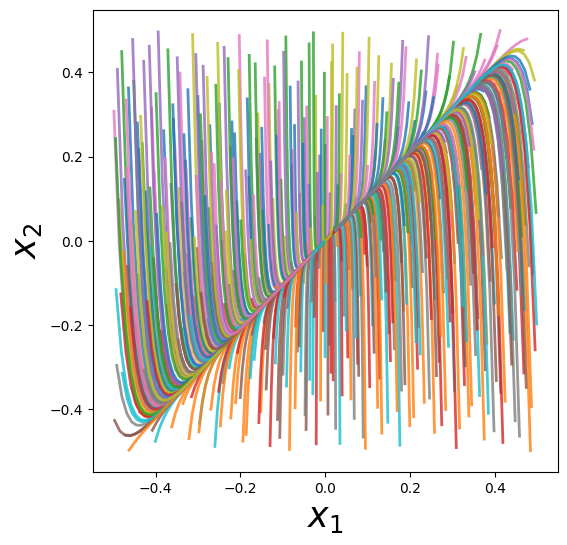

In [2]:
mu = -0.05
lda = -1.0
def slow_manifold(x, t, mu, lda):
    x1, x2 = x
    dxdt = [mu*x1, 
            lda*(x2-x1)]
    return dxdt

t = np.linspace(0, 50, 100,endpoint=False)

# use quasi-random for generating samples
sampler=Sobol(d=2)


x_list = []
x_next_list = []
plt.figure(figsize=(6,6))
for x0 in sampler.random(500)-0.5:
    sol = odeint(slow_manifold, x0, t, args=(mu,lda))
    plt.plot(sol[:,0],sol[:,1],'-',lw=2,alpha=0.8)
    
    x_list.append(sol[:-1])
    x_next_list.append(sol[1:])
    
plt.xlabel(r'$x_1$',size=25)
plt.ylabel(r'$x_2$',size=25)

# just choose one trajectory for demo

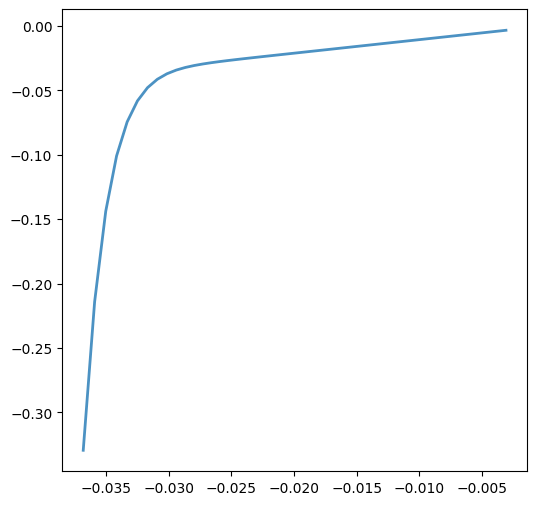

In [3]:
X = sol

plt.figure(figsize=(6,6))
plt.plot(sol[:,0],sol[:,1],'-',lw=2,alpha=0.8)

## TODO: in the future add multiple datasets capability
# X = np.vstack(x_list)
# X_NEXT = np.vstack(x_next_list)
# print(X.shape)
# print(X_NEXT.shape)

Check data size

In [4]:
print(X.shape)

(100, 2)


## DMD

In [5]:
from pydmd import DMD

regressor = DMD(svd_rank=2)
model_dmd = pk.Koopman(regressor=regressor)
model_dmd.fit(X)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x7f42906850c0>))

In [6]:
model_dmd.amplitudes

array([[-0.29060966],
       [-0.05344208]])

In [7]:
model_dmd.eigenvalues

array([0.60653069+0.j, 0.9753099 +0.j])

eigenvalues matches with ground truth very well

In [8]:
model_dmd.time['dt']=t[1]-t[0]
model_dmd.eigenvalues_continuous

array([-0.99999989+0.j, -0.05000001+0.j])

In [9]:
model_dmd.modes

array([[-3.74779466e-09,  6.88749504e-01],
       [ 1.00000000e+00,  7.24999393e-01]])

In [10]:
x0 = X[0:1]
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(X.shape[0]-1):
    x_tmp = model_dmd.predict(x_tmp)
    x_pred_list.append(x_tmp)
    
X_pred = np.vstack(x_pred_list)

Text(0, 0.5, '$x_2$')

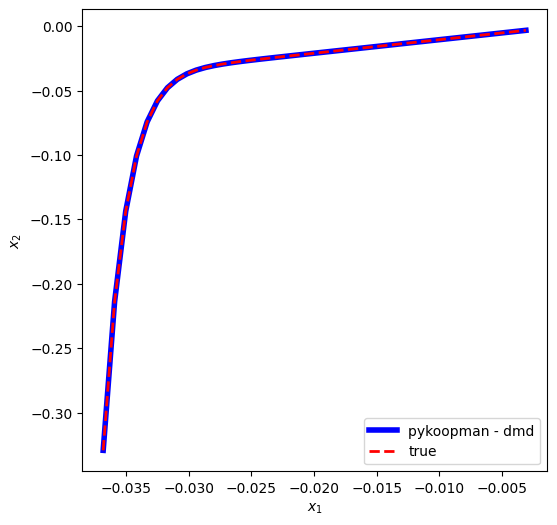

In [11]:
plt.figure(figsize=(6,6))
plt.plot(X_pred[:,0], X_pred[:,1],'-b',lw=4,label='pykoopman - dmd')
plt.plot(X[:,0],X[:,1],'r--',lw=2,label='true')
plt.legend(loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

## KDMD

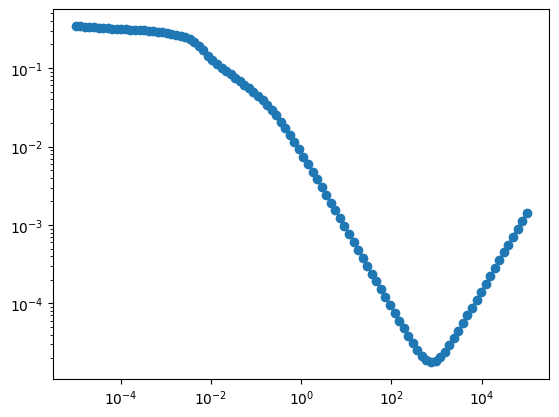

In [12]:
from pykoopman.regression import KDMD
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel

forward_backward=False
svd_rank = 3
tikhonov_regularization = 1e-9

err_list = []
# scale_array = np.logspace(-5,4.5,100)
scale_array = np.logspace(-5,5,100)
for scale in scale_array:

    regressor = KDMD(svd_rank=svd_rank, 
                     kernel=RBF(length_scale=np.sqrt(scale)),
                     forward_backward=forward_backward,
                     tikhonov_regularization=tikhonov_regularization)

    model = pk.Koopman(regressor=regressor)
    model.fit(X)

    # print(model.koopman_matrix.shape)

    err= np.linalg.norm(model.predict(model.regressor._X.T) - model.regressor._Y.T)

    err_list.append(err)
    
plt.loglog(scale_array, err_list,'-o')

choose the model with best hyperparameter, clearly here it is **overfitting** because we only have one trajectory

In [13]:
scale = scale_array[np.argmin(err_list)]
regressor = KDMD(svd_rank=svd_rank, 
                 kernel=RBF(length_scale=np.sqrt(scale)),
                 forward_backward=forward_backward,
                 tikhonov_regularization=tikhonov_regularization
                )

model = pk.Koopman(regressor=regressor)
model.fit(X)

Koopman(observables=Identity(),
        regressor=KDMD(kernel=RBF(length_scale=27.5), svd_rank=3,
                       tikhonov_regularization=1e-09))

Now we can see how good the model is at reconstructing the training data

In [14]:
x0 = X[0:1]
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(X.shape[0]-1):
    x_tmp = model.predict(x_tmp)
    x_pred_list.append(x_tmp)
    
X_pred = np.vstack(x_pred_list)

Text(0, 0.5, '$x_2$')

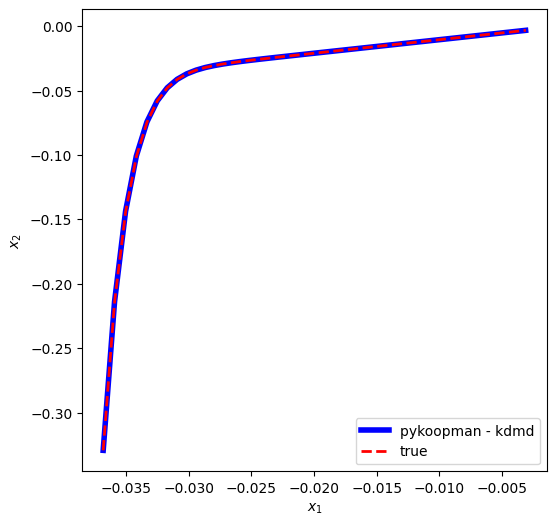

In [15]:
plt.figure(figsize=(6,6))
plt.plot(X_pred[:,0], X_pred[:,1],'-b',lw=4,label='pykoopman - kdmd')
plt.plot(X[:,0],X[:,1],'r--',lw=2,label='true')
plt.legend(loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

check Koopman eigenvalues, amplitudes

In [16]:
model.eigenvalues

array([0.6065004 , 1.00000046, 0.9751638 ])

The eigenvalues matches with ground truth very well

In [17]:
model.time['dt']=t[1]-t[0]
model.eigenvalues_continuous

array([-1.00009979e+00,  9.23797719e-07, -5.02996544e-02])

In [18]:
model.amplitudes

array([-0.29125559, -0.02234336, -0.03065754])

In [19]:
model.modes

array([[-1.10259169e-04,  9.99999994e-01],
       [ 7.03918360e-01,  7.10280890e-01],
       [ 6.88653485e-01,  7.25090600e-01]])

Validate the Koopman trajectory

In [20]:
X.shape

(100, 2)

In [21]:
efun_index, linearity_error = model.validity_check(t, X)

In [22]:
linearity_error

[4.493416580108399e-07, 6.20746554729928e-06, 6.058941654656838e-05]

In [23]:
efun_index

array([0, 2, 1])

## EDMD - Random Fourier Features - wait for Eurika's implementation